In [146]:
import pandas as pd
import numpy as np
from data_preprocess import Data

pop_df = Data.get_pop_df()
pop_df.head(5)

Getting raw population data
Using cached file: data\WPP2024_Demographic_Indicators_Medium.csv.gz
Parsing columns
Dropping countries with unreasonably large change
Dropped countries due to too big change:  Burundi Djibouti Eritrea Rwanda Somalia Western Sahara Liberia China, Hong Kong SAR China, Macao SAR Afghanistan Timor-Leste Jordan Kuwait Lebanon Oman Qatar United Arab Emirates Ukraine Andorra Bosnia and Herzegovina Kosovo (under UNSC res. 1244) Curaçao Montserrat Saint Martin (French part) Sint Maarten (Dutch part) Northern Mariana Islands


renaming: 100%|██████████| 12/12 [00:00<00:00, 226.76it/s]


renaming columns
Resolving country names to alpha_2


Solving alpha2 values: 100%|██████████| 211/211 [00:03<00:00, 70.27it/s]

Removing problematic countries data


,name,year,alpha_2,iso_2,population
0,Antigua and Barbuda,1950,AG,AG,44948
1,Antigua and Barbuda,1951,AG,AG,45939
2,Antigua and Barbuda,1952,AG,AG,46901
3,Antigua and Barbuda,1953,AG,AG,47893
4,Antigua and Barbuda,1954,AG,AG,48872


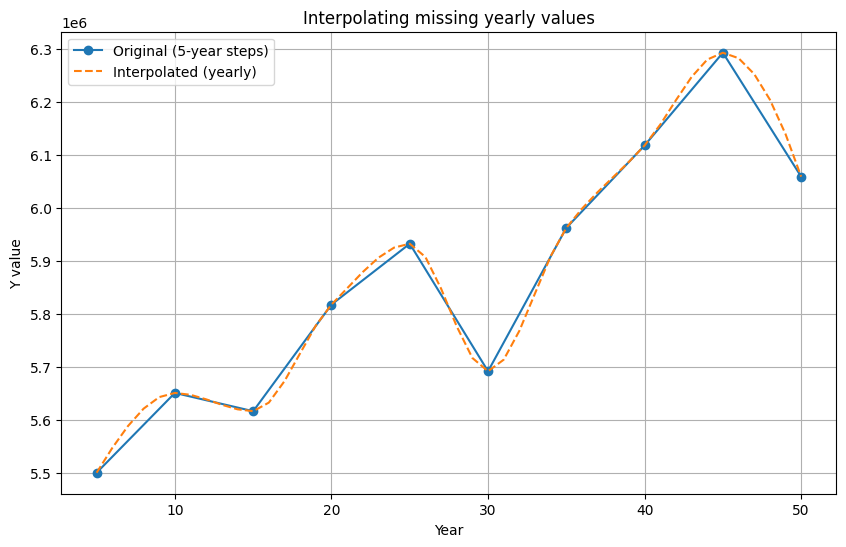

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

def solve_missing_values(y, x):
    all_years = np.arange(min(x), max(x) + 1, 1)
    interp = PchipInterpolator(x, y)
    return interp(all_years), all_years

n = 10
start_val = 5.5 * 10**6
x = list(range(5, 55, 5))  # [5, 10, ..., 50]

# Generate values with ±5% change
y = [start_val]
rng = np.random.default_rng(seed=42)  # reproducible random numbers
for _ in range(n - 1):
    change_factor = 1 + rng.uniform(-0.05, 0.05)  # between -5% and +5%
    y.append(y[-1] * change_factor)

# Example data (replace with your own)

y_smooth, all_years = solve_missing_values(y, x)

# Plot
plt.figure(figsize=(10,6))
plt.plot(x, y, "o-", label="Original (5-year steps)")
plt.plot(all_years, y_smooth, "--", label="Interpolated (yearly)")
plt.xlabel("Year")
plt.ylabel("Y value")
plt.title("Interpolating missing yearly values")
plt.legend()
plt.grid(True)
plt.show()


(19500, 18)


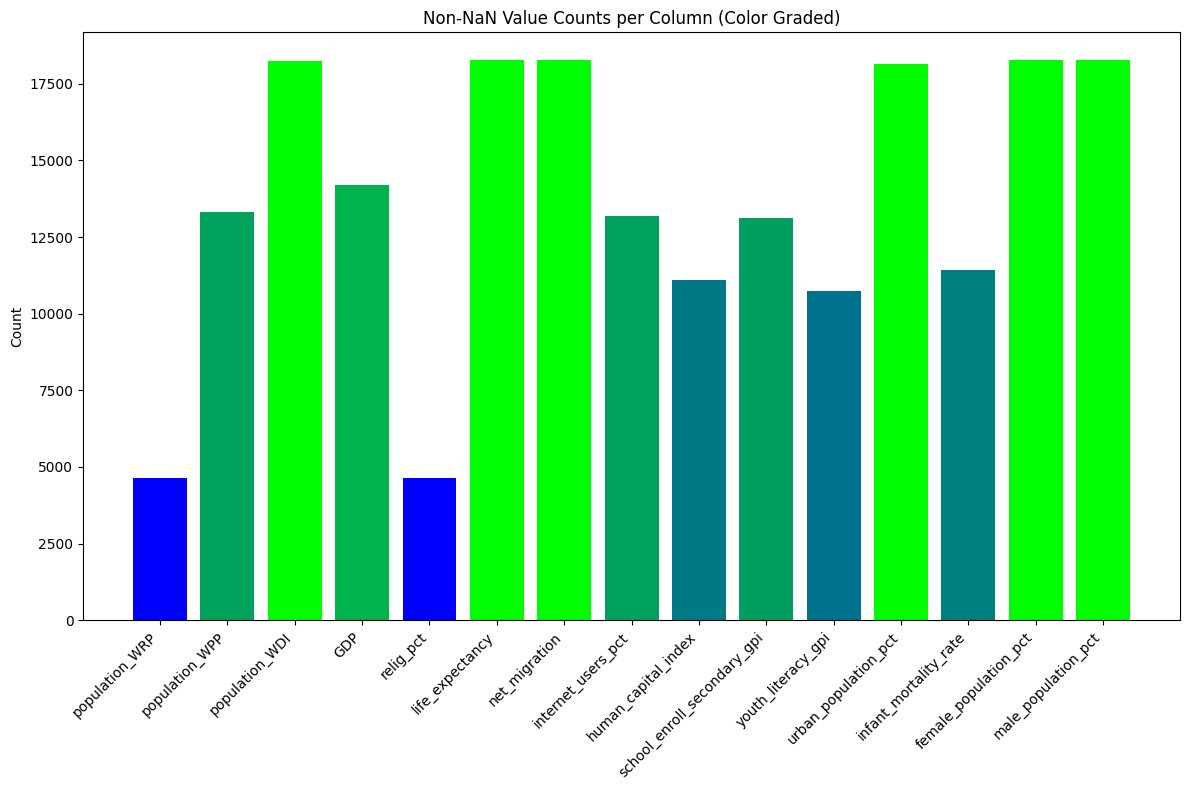

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def fill_internet_users_before_first(df):
    df = df.copy()
    
    for country, g in df.groupby("name"):
        first_valid = g["internet_users_pct"].first_valid_index()
        if first_valid is not None:
            # Get all indices for this country that are before first_valid
            mask = g.index[g.index < first_valid]
            # Set those to 0 if they are NaN
            df.loc[mask, "internet_users_pct"] = df.loc[mask, "internet_users_pct"].fillna(0)
    return df



# Load data
df = pd.read_csv("data\\cleaned_all_data.csv")
df = df[(df["year"] >= 1960)]
drop_names = [
    "Jordan",
    "Saudi Arabia",
    "Afghanistan",
    "Moldova",
    "Lebanon",
    "Cyprus",
    "Somalia",
]

df = df[~df["name"].isin(drop_names)]

rename_map = {
    'Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]': 'fertility_rate',
    'Birth rate, crude (per 1,000 people) [SP.DYN.CBRT.IN]': 'birth_rate',
    'Death rate, crude (per 1,000 people) [SP.DYN.CDRT.IN]': 'death_rate',
    'Life expectancy at birth, total (years) [SP.DYN.LE00.IN]': 'life_expectancy',
    'Net migration [SM.POP.NETM]': 'net_migration',
    'Individuals using the Internet (% of population) [IT.NET.USER.ZS]': 'internet_users_pct',
    'Gini index [SI.POV.GINI]': 'gini_index',
    'Human capital index (HCI) (scale 0-1) [HD.HCI.OVRL]': 'human_capital_index',
    'School enrollment, secondary (gross), gender parity index (GPI) [SE.ENR.SECO.FM.ZS]': 'school_enroll_secondary_gpi',
    'Literacy rate, youth (ages 15-24), gender parity index (GPI) [SE.ADT.1524.LT.FM.ZS]': 'youth_literacy_gpi',
    'Urban population (% of total population) [SP.URB.TOTL.IN.ZS]': 'urban_population_pct',
    'Mortality rate, infant (per 1,000 live births) [SP.DYN.IMRT.IN]': 'infant_mortality_rate',
    'Current health expenditure per capita, PPP (current international $) [SH.XPD.CHEX.PP.CD]': 'health_expenditure_per_capita_ppp',
    'Population, female (% of total population) [SP.POP.TOTL.FE.ZS]': 'female_population_pct',
    'Population, male (% of total population) [SP.POP.TOTL.MA.ZS]': 'male_population_pct',
    'Population, total [SP.POP.TOTL]': 'population_WDI',
    'pop': 'population_WRP',
    'population': 'population_WPP',
}

relig_cols = ["christian", "islam", "buddhist", "judaism", "other"]

# Require all values present, otherwise NaN
df["relig_pct"] = df[relig_cols].sum(axis=1, skipna=False)

# Drop old columns
df.drop(columns=relig_cols, inplace=True)
columns_of_interest = [
    'name',
    'alpha_2',
    'year',
    'population_WRP',
    'population_WPP',
    'population_WDI',
    'GDP',
    'relig_pct',
    'life_expectancy',
    'net_migration',
    'internet_users_pct',
    'human_capital_index',
    'school_enroll_secondary_gpi',
    'youth_literacy_gpi',
    'urban_population_pct',
    'infant_mortality_rate',
    'female_population_pct',
    'male_population_pct',
    ]
df.rename(columns=rename_map, inplace=True)
df = df[[col for col in columns_of_interest if col in df.columns]]
df = fill_internet_users_before_first(df)
# df = df[df["population_WDI"] >= 500_000]
df.to_csv("data/all_data.csv")
# Semantic type mapping
semantic_map = {
    # absolute counts
    "population_WRP": "count",
    "population_WPP": "count",
    "population_WDI": "count",
    "GDP": "count",
    "net_migration": "count",

    # percentages
    "relig_pct": "percentage",
    "internet_users_pct": "percentage",
    "school_enroll_secondary_gpi": "percentage",
    "youth_literacy_gpi": "percentage",
    "urban_population_pct": "percentage",
    "female_population_pct": "percentage",
    "male_population_pct": "percentage",

    # relative indices
    "human_capital_index": "relative_index",

    # other continuous measures (treat as relative index)
    "life_expectancy": "relative_index",
    "infant_mortality_rate": "relative_index",
}

# Attach attrs to columns
for col, sem_type in semantic_map.items():
    if col in df.columns:
        df[col].attrs["semantic_type"] = sem_type





# Exclude the first five columns
excluded_columns = df.columns[:3]
df_remaining = df.drop(columns=excluded_columns)

# Count non-NaN values per remaining column
non_nan_counts = df_remaining.notna().sum()

# Normalize values for color mapping (0 to 1 scale)
norm = (non_nan_counts - non_nan_counts.min()) / (non_nan_counts.max() - non_nan_counts.min())

# Create colors: from blue (low) to green (high)
colors = [(0, n, 1 - n) for n in norm]  # RGB tuples: blue to green

# Plot
print(df.shape)
plt.figure(figsize=(12, 8))
bars = plt.bar(non_nan_counts.index, non_nan_counts.values, color=colors)
plt.title("Non-NaN Value Counts per Column (Color Graded)")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [150]:
pop_cols = ["population_WRP", "population_WPP", "population_WDI"]
df_diff = df.copy()
# Compute relative difference between max and min across sources
df_diff["pop_rel_diff"] = (
    df_diff[pop_cols].max(axis=1) - df_diff[pop_cols].min(axis=1)
) / df_diff[pop_cols].min(axis=1)

df_mismatch = df_diff[df_diff["pop_rel_diff"] > 0.20]
df_mismatch.shape


(75, 19)

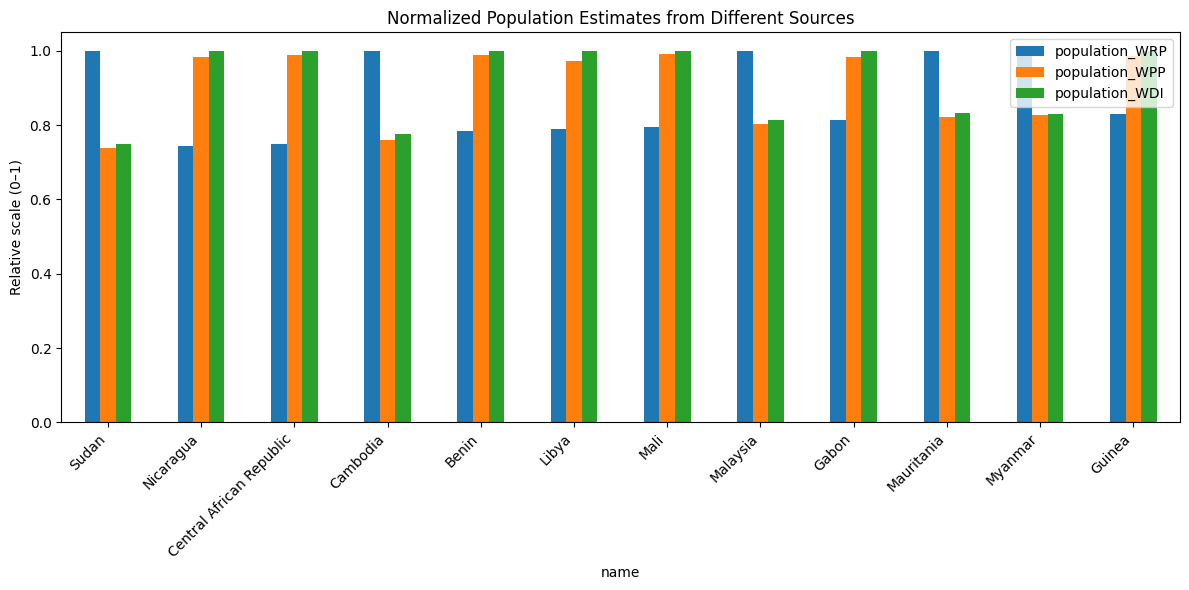

In [157]:
import matplotlib.pyplot as plt

# Pick top 10 mismatches (one per country)
subset = (
    df_mismatch.sort_values("pop_rel_diff", ascending=False)
    .drop_duplicates(subset="name", keep="first")
    .set_index("name")
)

# Normalize values row-wise (each country scaled 0–1)
subset_norm = subset[pop_cols].div(subset[pop_cols].max(axis=1), axis=0)

# Plot normalized
subset_norm.plot(kind="bar", figsize=(12,6))
plt.title("Normalized Population Estimates from Different Sources")
plt.ylabel("Relative scale (0–1)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


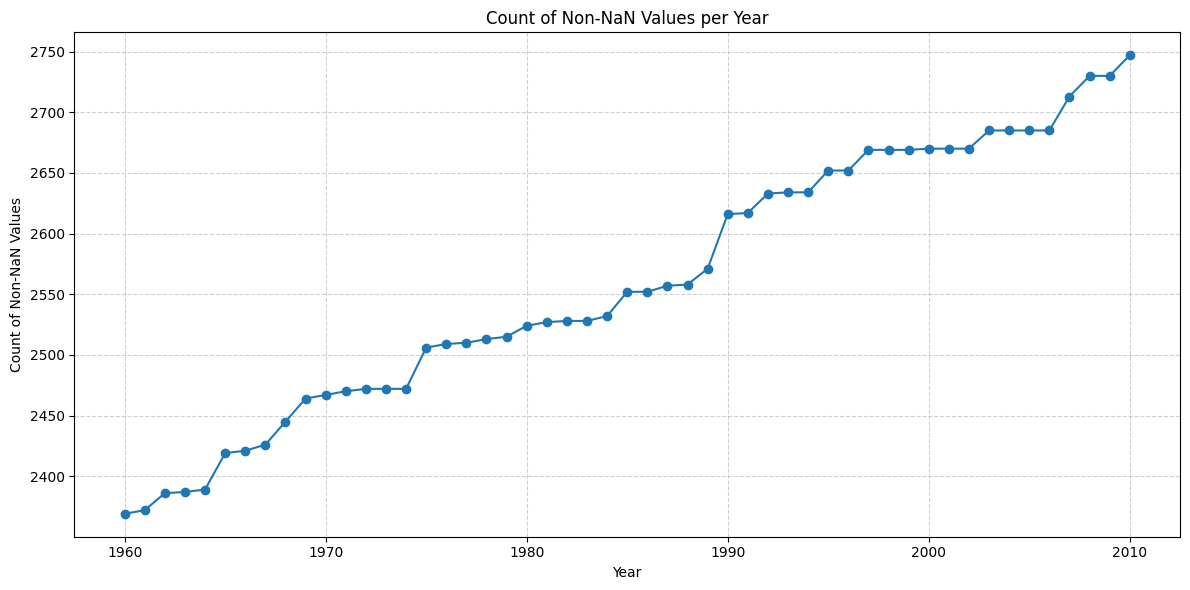

In [152]:
import matplotlib.pyplot as plt

# Count non-NaN rows for each year (across all columns except country_name)
year_counts = (
    df_diff.drop(columns=["name"])     # drop non-numeric identifier column
      .notna()                            # True for non-NaN
      .groupby(df_diff["year"])                # group by year
      .sum()                              # sum True values → count of non-NaNs per column
)

# Total non-NaN values per year across all columns
year_counts["total_non_nan"] = year_counts.sum(axis=1)

# Plot
plt.figure(figsize=(12,6))
plt.plot(year_counts.index, year_counts["total_non_nan"], marker="o")
plt.title("Count of Non-NaN Values per Year")
plt.xlabel("Year")
plt.ylabel("Count of Non-NaN Values")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


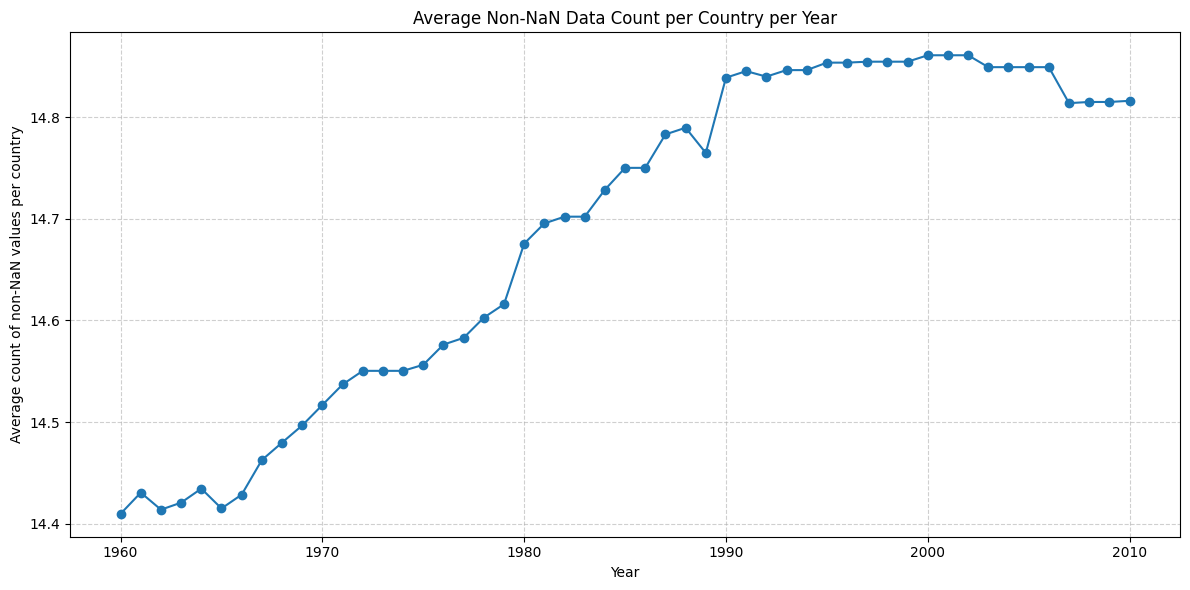

In [153]:
import matplotlib.pyplot as plt

# Exclude non-data columns
data_cols = [c for c in df.columns if c not in ["name", "year"]]

# Count non-NaN values per year per country
year_country_counts = (
    df.groupby("year")[data_cols]
      .apply(lambda g: g.notna().sum(axis=1))   # count non-nans per row
)

# Total non-NaN values per year
total_counts_per_year = year_country_counts.groupby("year").sum()

# Number of countries with at least one non-NaN value that year
countries_per_year = (
    df.groupby("year")["name"]
      .nunique()
)

# Average data count per country
average_data_count_per_country = total_counts_per_year / countries_per_year

# Plot
plt.figure(figsize=(12,6))
plt.plot(average_data_count_per_country.index,
         average_data_count_per_country.values,
         marker="o")

plt.title("Average Non-NaN Data Count per Country per Year")
plt.xlabel("Year")
plt.ylabel("Average count of non-NaN values per country")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


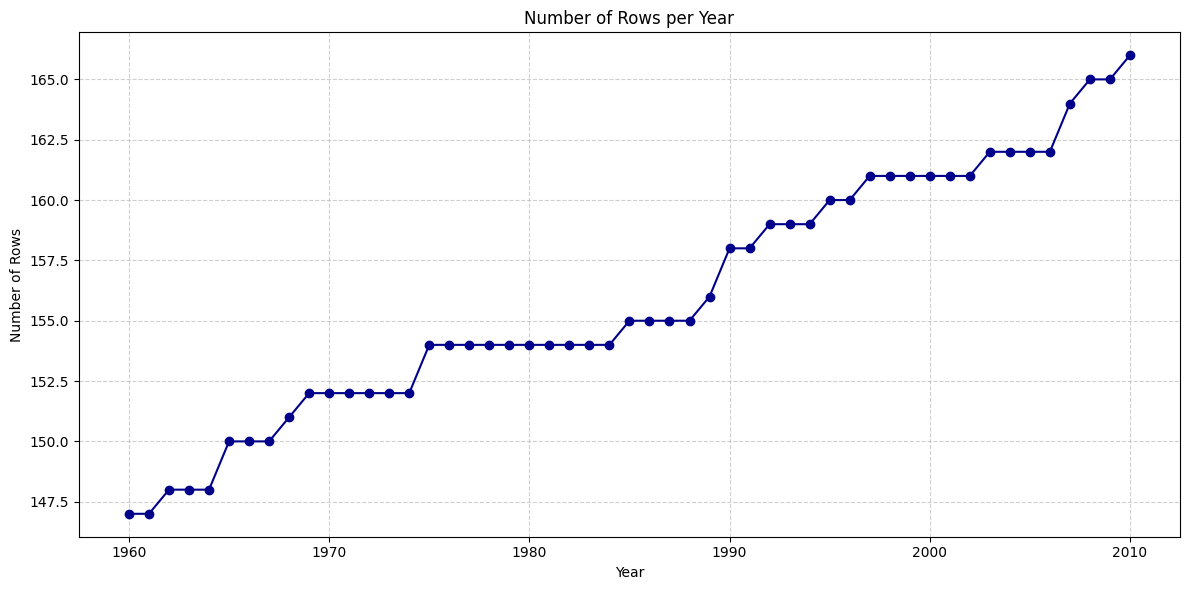

In [154]:
import matplotlib.pyplot as plt

# Count rows per year
rows_per_year = df.groupby("year").size()

# Plot
plt.figure(figsize=(12,6))
plt.plot(rows_per_year.index, rows_per_year.values, marker="o", color="darkblue")
plt.title("Number of Rows per Year")
plt.xlabel("Year")
plt.ylabel("Number of Rows")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


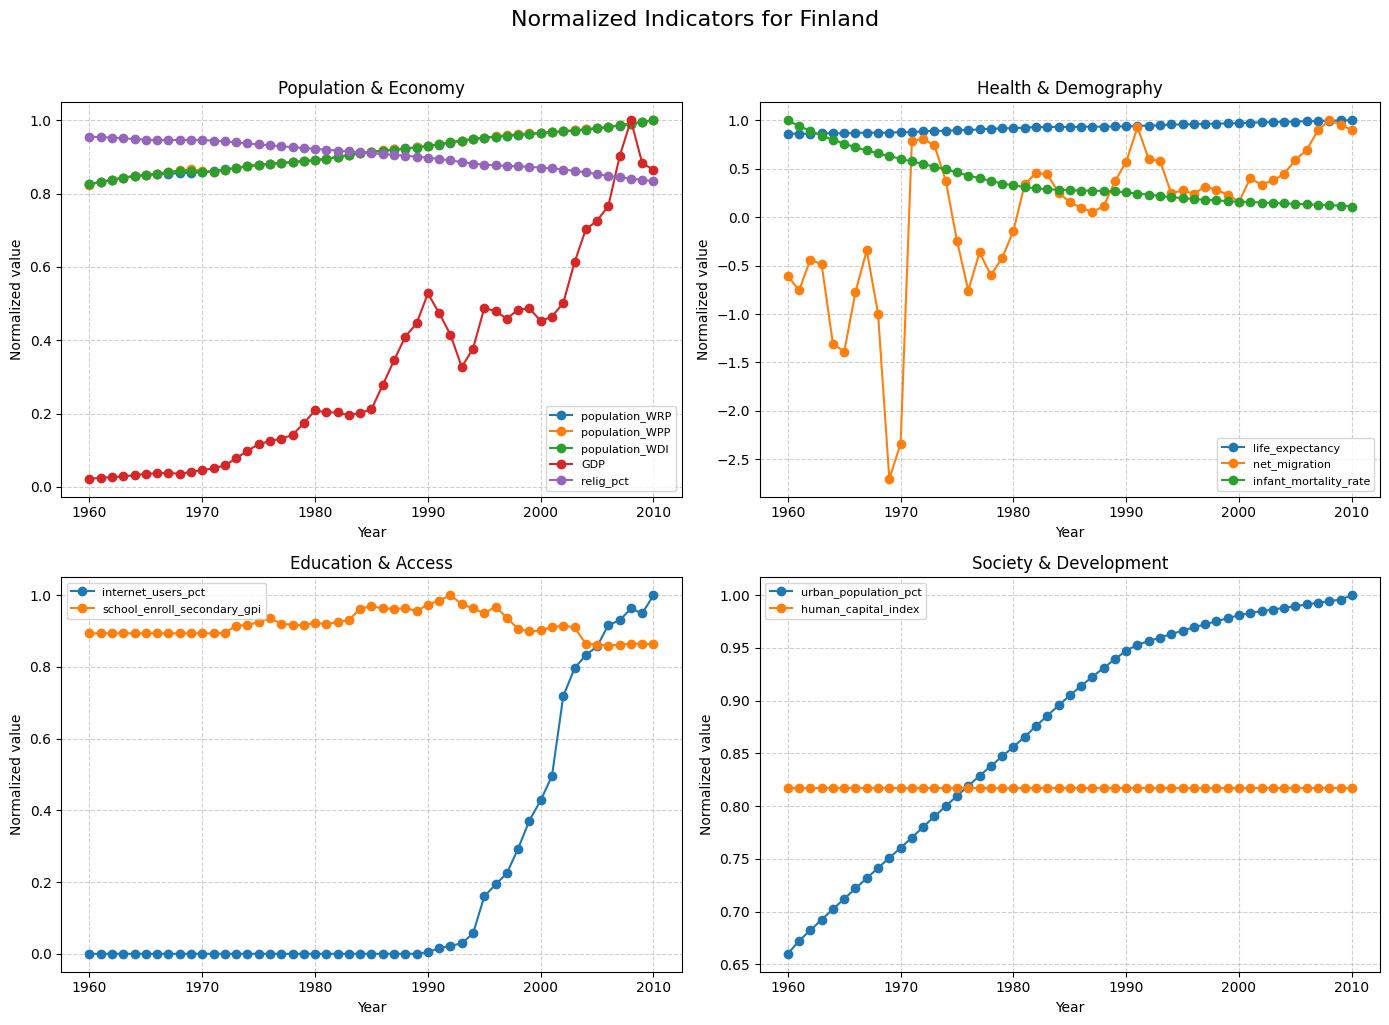

In [155]:
import matplotlib.pyplot as plt

def plot_country(country_name, df):
    # Select the country
    df_country = df[df["name"] == country_name].set_index("year")
    
    # Exclude non-numeric columns
    numeric_cols = df_country.select_dtypes(include=["number"])
    
    if numeric_cols.empty:
        print(f"No numeric data available for {country_name}")
        return
    
    # --- Normalization function ---
    def normalize_series(series):
        col_min, col_max = series.min(), series.max()
        if col_min >= 0 and col_max <= 1:  # already 0–1
            return series
        max_val = col_max if col_max != 0 else 1
        return series / max_val
    
    # Normalize all numeric columns
    normalized = numeric_cols.apply(normalize_series, axis=0)
    
    # --- Groups of columns for subplots ---
    groups = {
        "Population & Economy": [
            'population_WRP', 'population_WPP', 'population_WDI', 'GDP', 'relig_pct'
        ],
        "Health & Demography": [
            'life_expectancy', 'net_migration', 'infant_mortality_rate'
        ],
        "Education & Access": [
            'youth_literacy_gpi', 'internet_users_pct', 'school_enroll_secondary_gpi'
        ],
        "Society & Development": [
            'urban_population_pct', 'human_capital_index'
        ]
    }
    
    # --- Plot ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for ax, (title, cols) in zip(axes, groups.items()):
        available = [c for c in cols if c in normalized.columns]
        subset = normalized[available].dropna(axis=1, how="all")

        for col in subset.columns:
            try:
                ax.plot(subset.index, subset[col], marker="o", label=col)
            except:
                pass
        ax.set_title(title)
        ax.set_xlabel("Year")
        ax.set_ylabel("Normalized value")
        ax.legend(fontsize=8)
        ax.grid(True, linestyle="--", alpha=0.6)
    
    fig.suptitle(f"Normalized Indicators for {country_name}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
plot_country("Finland", df)


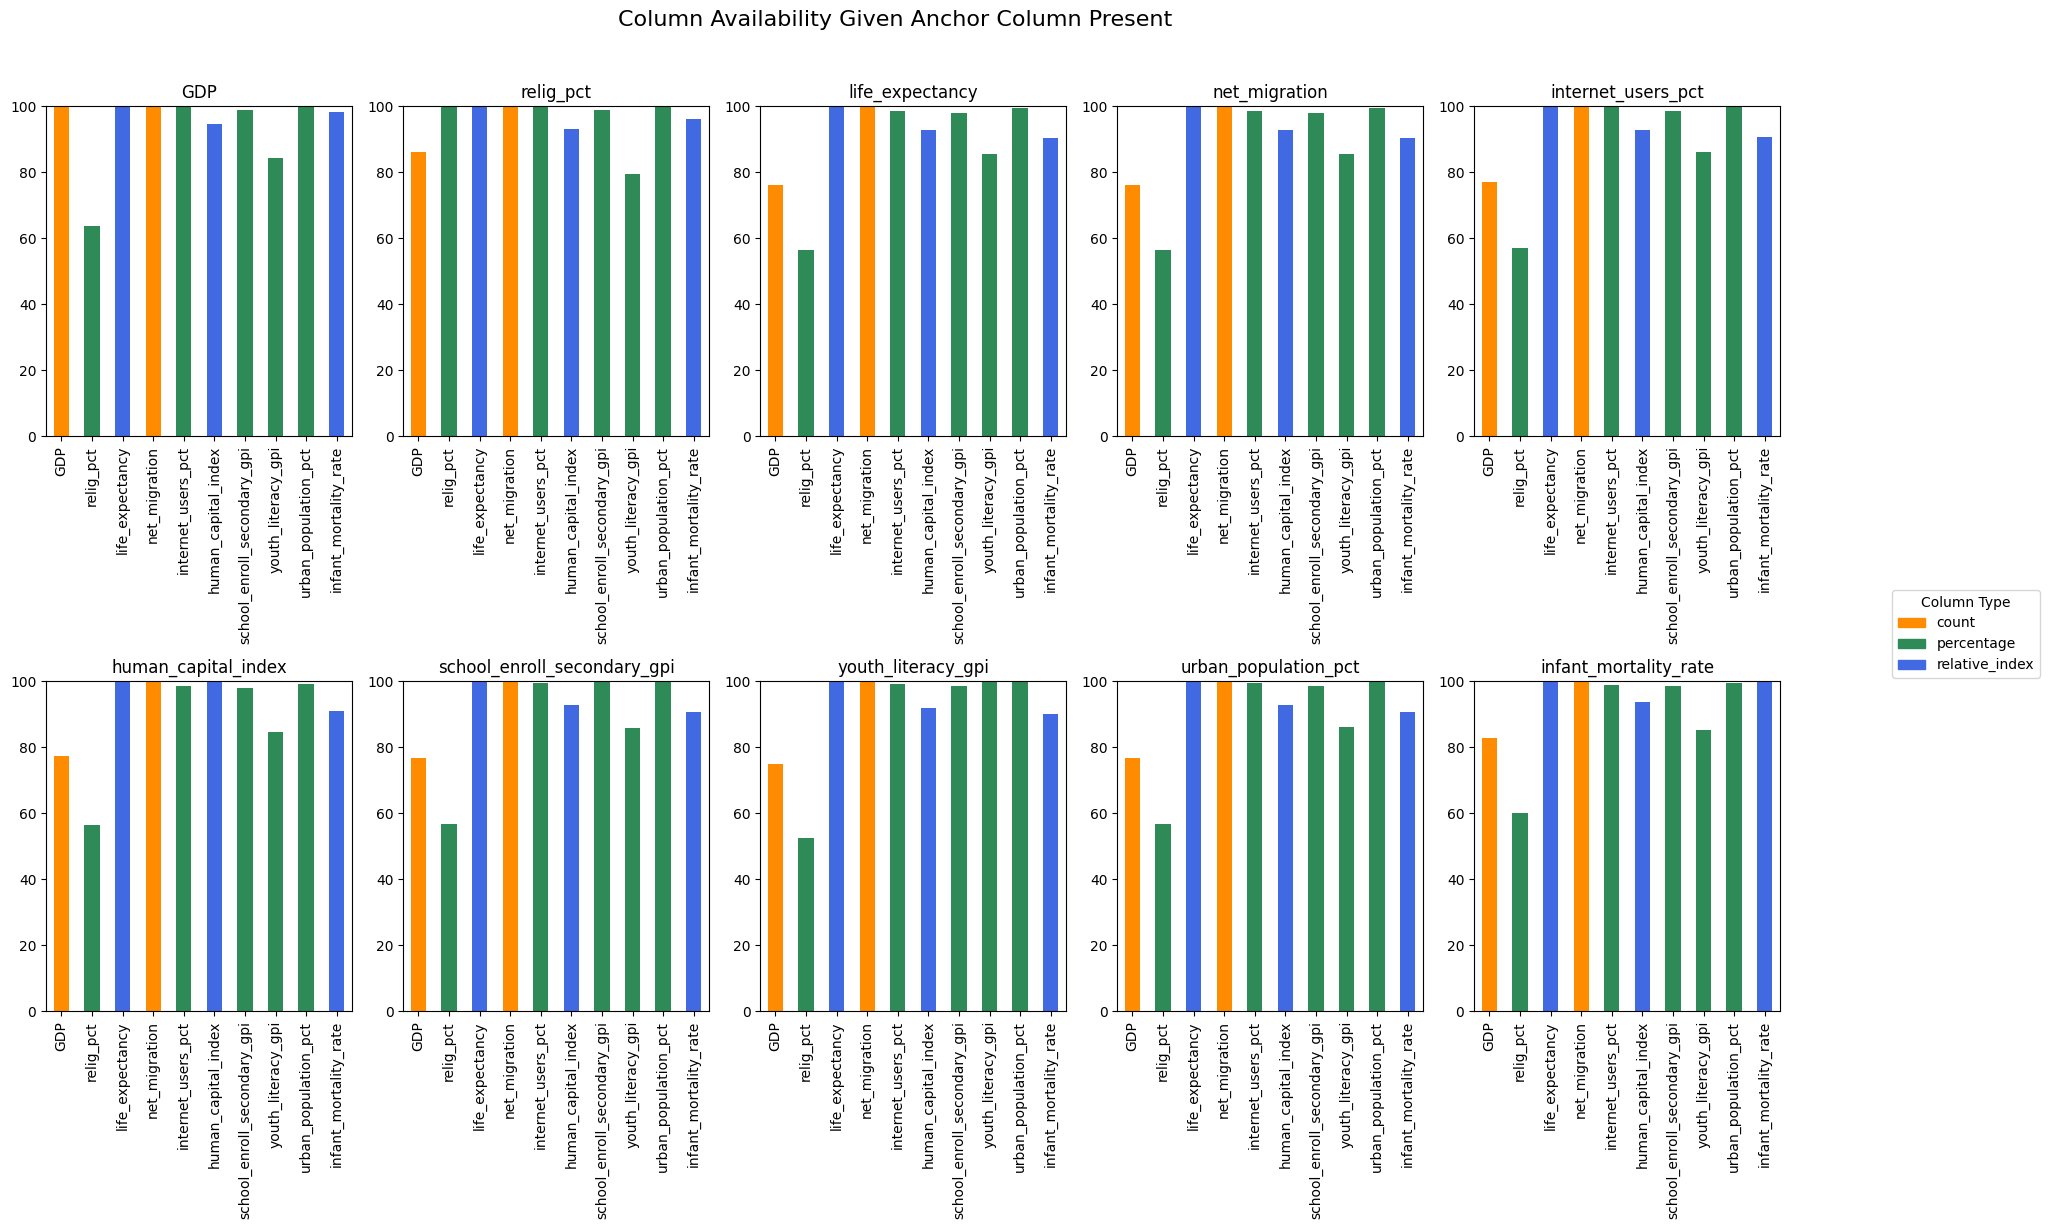

In [156]:
import matplotlib.pyplot as plt

cols = [
    'GDP',
    'relig_pct',
    'life_expectancy',
    'net_migration',
    'internet_users_pct',
    'human_capital_index',
    'school_enroll_secondary_gpi',
    'youth_literacy_gpi',
    'urban_population_pct',
    'infant_mortality_rate',
]

# Semantic type mapping (same as before)
semantic_map = {
    "GDP": "count",
    "net_migration": "count",
    "relig_pct": "percentage",
    "internet_users_pct": "percentage",
    "school_enroll_secondary_gpi": "percentage",
    "youth_literacy_gpi": "percentage",
    "urban_population_pct": "percentage",
    "human_capital_index": "relative_index",
    "life_expectancy": "relative_index",
    "infant_mortality_rate": "relative_index",
}

# Assign colors by semantic type
color_map = {
    "count": "darkorange",
    "percentage": "seagreen",
    "relative_index": "royalblue"
}
bar_colors = {col: color_map[semantic_map[col]] for col in cols}

# --- Plot ---
fig, axes = plt.subplots(2, 5, figsize=(18, 12))
axes = axes.flatten()

for i, anchor in enumerate(cols):
    ax = axes[i]
    
    # Subset rows where anchor column is not NaN
    subset = df[df[anchor].notna()]
    
    if subset.empty:
        ax.set_title(anchor)
        ax.axis("off")
        continue
    
    # Compute percentages
    percentages = subset[cols].notna().mean() * 100
    
    # Use consistent colors for each column
    colors = [bar_colors[c] for c in percentages.index]
    
    percentages.plot(kind="bar", ax=ax, color=colors)
    ax.set_title(anchor)
    ax.set_ylim(0, 100)  # percentage scale
    ax.tick_params(axis="x", labelrotation=90)

# Shared legend for semantic types
handles = [plt.Rectangle((0,0),1,1, color=c) for c in color_map.values()]
labels = list(color_map.keys())
fig.legend(handles, labels, title="Column Type", bbox_to_anchor=(1.05, 0.5), loc="center left")

plt.suptitle("Column Availability Given Anchor Column Present", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


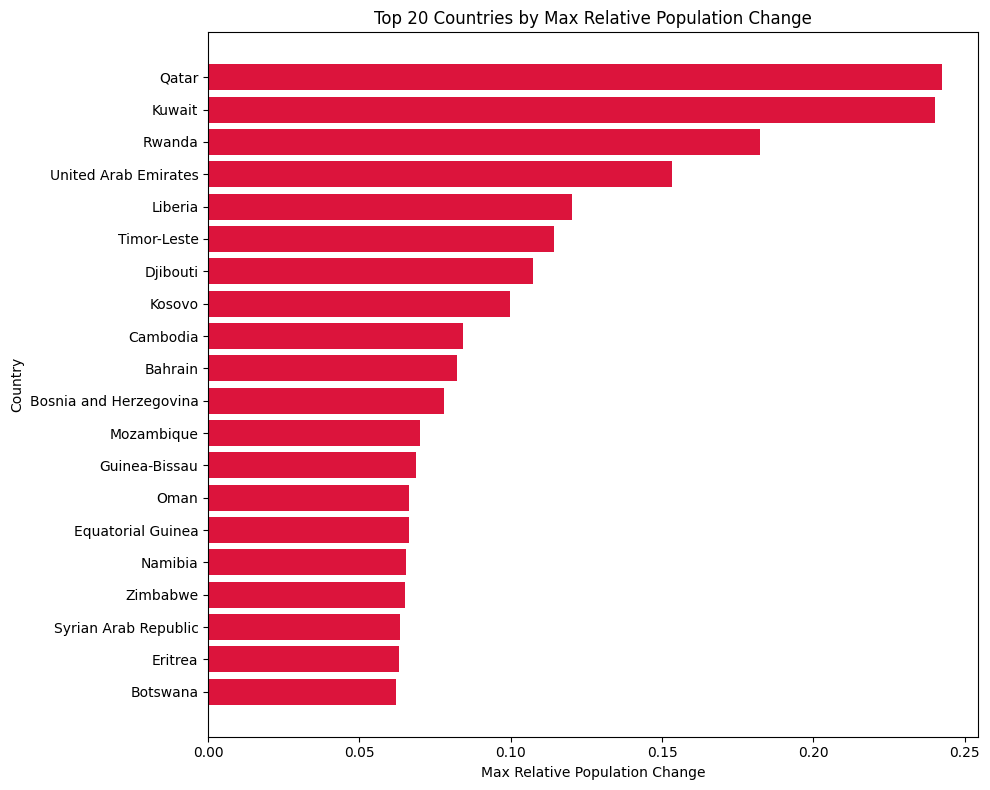

In [174]:
from data_preprocess import Data
countries_all_nan_relig = (
    df.groupby("name")["relig_pct"]
      .apply(lambda x: x.isna().all())
      .loc[lambda s: s]  # keep only True
      .index.tolist()
)
# print(countries_all_nan_relig)
rdf = pd.read_csv("data/raw_relig_data.csv")
# dupes = rdf[rdf.duplicated(subset=["name", "year"], keep=False)]
# print(dupes.sort_values(["name", "year"]))
countries = rdf["name"].unique()
# print(countries)
# crdf = Data.clean_relig_data(rdf)

changes = Data.get_country_pop_max_relative_change(df, c_pop = "population_WDI")
# for key, val in changes.items():
#     print(key, val)

import matplotlib.pyplot as plt

# Take the top 20 largest changes
# top_changes = dict(sorted(changes.items(), key=lambda x: x[1], reverse=True)[:20])
top_changes = dict(sorted(changes.items(), key=lambda x: x[1], reverse=True)[:20])
plt.figure(figsize=(10, 8))
plt.barh(list(top_changes.keys()), list(top_changes.values()), color="crimson")
plt.xlabel("Max Relative Population Change")
plt.ylabel("Country")
plt.title("Top 20 Countries by Max Relative Population Change")
plt.gca().invert_yaxis()  # largest at top
plt.tight_layout()
plt.show()
